In [29]:
import numpy as np
import pandas as pd

# import gensim
# from gensim.utils import simple_preprocess
# from gensim import corpora, models

# from nltk.stem import WordNetLemmatizer
# import nltk
# nltk.download('wordnet')
# from nltk.tokenize import TweetTokenizer
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english'))
# from symspellpy.symspellpy import SymSpell, Verbosity
# from sklearn.model_selection import train_test_split

import warnings;
warnings.filterwarnings('ignore');

import process_tweet
import importlib
importlib.reload(process_tweet)

from sklearn.preprocessing import StandardScaler
def normalize_df(df):
    normed = StandardScaler().fit_transform(df)
    return pd.DataFrame(normed, columns=df.columns)

[nltk_data] Downloading package wordnet to /home/ashwin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
# df = pd.read_csv('data/labeled_prelim.csv').dropna().astype(
#         {'Relevancy':np.int32, 'Urgency':np.int32}).reset_index(drop=True)
# df.pop('Id')

# df2 = pd.read_csv('data/mturk_results_0-2000_processed.csv')
# df = pd.concat([df, df2], ignore_index=True)
# df2 = pd.read_csv('data/final_dataset.csv')
# df = df2

df = pd.read_csv('data/final_dataset_processed.csv')

print(df.shape)
df.head()

(4078, 3)


,Text,Relevancy,Urgency
0,harveystorm water waist deep respect cop help ...,0,0
1,find help affect hurricane harvey yeg hurrican...,1,0
2,mountainview heroes deploy help harvey <url>,3,0
3,help impact hurricaneharvey weave activate don...,0,0
4,much flood houston wow tune news prayers sympa...,0,0


In [31]:
sum(map(lambda x: 1 if x > 0 else 0, df['Relevancy']))/4078

0.5

In [32]:
sum(df['Urgency'])/4078

0.06817067189798921

In [33]:
#list of embeddings
vec_length = 100
embeddings = np.zeros((1193514, vec_length))

#two-way map, index->word and word->index
glove = {}

index = 0
with open('data/glove.twitter.27B/glove.twitter.27B.%dd.txt' % vec_length) as f:
    for l in f:
        line = []
        try:
            line = l.split()
            if len(line) != vec_length+1:
                print('empty line')
                continue
            
            word = line[0]
            embeddings[index] = np.array(line[1:]).astype(np.float)
            glove[index] = word
            glove[word] = index
            index += 1
        except:
            print(line)
            print(index)
            break

empty line


In [42]:
sym_spell = create_symspell(2,7,'data/frequency_dictionary_en_82_765.txt')
tknzr = TweetTokenizer(strip_handles=False, reduce_len=True)
df['Text'] = df['Text'].map(lambda x: process_tweet.process_tweet(x, glove, tknzr, sym_spell, True))
df.head()

,Text,Relevancy,Urgency
0,harveystorm water waist deep respect cop help ...,0,0
1,find help affect hurricane harvey yeg hurrican...,1,0
2,mountainview heroes deploy help harvey <url>,3,0
3,help impact hurricaneharvey weave activate don...,0,0
4,much flood houston wow tune news prayers sympa...,0,0


In [45]:
process_tweet.process_tweet('@user #hello world thedogeats', glove, tknzr, sym_spell,True)

'<user> hello world dog eat'

In [34]:
#only handles binary classification for now
def tweets_to_df(df, labels, embeddings, glove):
    
    weights = []
    index_omit = []
    index = -1
    tweets = df['Text']
    
    #a column for each entry in the embedding vector
    for i in range(vec_length+1):
        weights.append([])
    
    for i in range(len(tweets)):
        index += 1
        cur_embed = []
        cur_tweet = tweets[i]
        cur_label = labels[i]
        for i in cur_tweet.split():
            if i in glove:
                cur_embed.append(embeddings[glove[i]])
        
        if len(cur_embed) == 0:
            #make sure we drop this row from the input dataframe
            index_omit.append(index)
            continue
        
        x = np.asarray(np.mean(cur_embed, axis=0))
        
        for j in range(vec_length):
            weights[j].append(x[j])
        weights[vec_length].append(0 if cur_label == 0 else 1)
        #weights[vec_length].append(cur_label)
        
    df_pruned = df.drop(index_omit)
    
    #convert to dataframe
    cols = {}
    for i in range(vec_length):
       cols['v' + str(i)] = weights[i]
    
    cols['class'] = weights[vec_length]
    
    df2 = pd.DataFrame(data=cols)
    return df2

In [35]:
dfv = tweets_to_df(df, df['Relevancy'], embeddings, glove)
labels = dfv.pop('class')
dfv.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,0.003221,0.168270,-0.013087,-0.023372,0.025830,-0.080921,0.378779,0.093189,-0.074569,0.106660,...,0.122259,-0.047985,0.128286,-0.094838,-0.068746,-0.044817,-0.193389,0.082613,0.066145,0.130523
1,0.328041,0.373477,-0.085249,-0.168861,0.164855,-0.131659,0.272753,-0.007647,0.037618,-0.091781,...,-0.077606,-0.268406,0.212094,-0.183310,-0.010376,-0.095017,-0.032550,0.222394,0.228733,0.057846
2,0.257268,0.352282,0.035927,0.046052,-0.096611,-0.229522,0.241063,0.085318,0.018254,-0.255575,...,-0.006639,-0.003842,0.226735,-0.205175,0.384275,-0.094385,-0.108704,0.167798,0.208930,0.104100
3,0.357346,0.160738,-0.289289,-0.122491,0.105139,-0.183092,0.392284,0.029195,0.082386,-0.102307,...,-0.126154,-0.205025,0.219874,-0.437095,0.078640,-0.122534,0.121756,-0.149561,0.163541,-0.077947
4,0.313908,0.621902,-0.121154,-0.254075,-0.023061,-0.044489,0.235307,0.406984,-0.009640,-0.020257,...,-0.037587,-0.168589,0.258516,0.186098,-0.258723,-0.051804,0.103654,0.203003,0.186003,-0.121892


In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import * 
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import *
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

def average(x):
    return sum(x)/len(x)

def get_stats(model, X, y, cv, verbose=False):
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    auc = []
        
    cv_results = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], 
                                cv=cv, return_train_score=False)
    
    if verbose:
        print(cv_results)
    
    #now return the data
    return cv_results

def print_stats(models, method, dfv, labels):
    
    vals = []
    metric = []
    model_name = []

    f1 = []
    precision = []
    recall = []
    accuracy = []
    auc = []

    cv = 10
    for k,v in models.items():
        stats = get_stats(v, dfv, labels, cv)
        accuracy_avg = np.average(stats['test_accuracy'])
        accuracy_std = np.std(stats['test_accuracy'])
        precision_avg = np.average(stats['test_precision'])
        precision_std = np.std(stats['test_precision'])
        recall_avg = np.average(stats['test_recall'])
        recall_std = np.std(stats['test_recall'])
        f1_avg = np.average(stats['test_f1'])
        f1_std = np.std(stats['test_f1'])
        auc_avg = np.average(stats['test_roc_auc'])

        f1.append('%.2f ± %.2f' % (f1_avg, f1_std))
        precision.append('%.2f ± %.2f' % (precision_avg, precision_std))
        recall.append('%.2f ± %.2f' % (recall_avg, recall_std))
        accuracy.append('%.2f ± %.2f' % (accuracy_avg, accuracy_std))
        auc.append('%.2f' % auc_avg)

    df_view = pd.DataFrame(data={'Method': method, 'f1': f1, 
                                 'precision':precision, 'recall':recall,
                                 'accuracy':accuracy, 'auc':auc})
    display(df_view)

In [37]:
models = {'Naive Bayes': GaussianNB(),
          'Voting': VotingClassifier(estimators=[('mlp', MLPClassifier()),
                                            ('ada', AdaBoostClassifier()),
                                            ('nb', GaussianNB())], voting='soft'),
          'Perceptron': MLPClassifier(),
          'AdaBoost': AdaBoostClassifier(),
          'Support Vector Machine': SVC()
        }
method = ['Naive Bayes', 'Voting', 'MLP', 'AdaBoost', 'Support Vector Machine']
print_stats(models, method, dfv, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.68 ± 0.02,0.60 ± 0.02,0.78 ± 0.04,0.63 ± 0.03,0.71
1,Voting,0.70 ± 0.02,0.64 ± 0.03,0.77 ± 0.03,0.67 ± 0.03,0.75
2,MLP,0.68 ± 0.02,0.68 ± 0.02,0.68 ± 0.04,0.68 ± 0.02,0.74
3,AdaBoost,0.66 ± 0.02,0.65 ± 0.02,0.67 ± 0.03,0.65 ± 0.02,0.71
4,Support Vector Machine,0.68 ± 0.02,0.69 ± 0.02,0.66 ± 0.03,0.68 ± 0.02,0.74


## Feature Selection

We first try using randomized logistic regression to extract the most useful features from the 50.

In [18]:
from sklearn.linear_model import LogisticRegression

#Use randomized lasso to select most useful subset of features
rlog = RandomizedLogisticRegression()
rlog.fit(dfv, labels)

names = map(lambda x: 'v'+str(x), range(vec_length))
features = sorted(zip(rlog.scores_, names))

print('Ranked Features:')
print(features)

#now create a modified dataset with only features with score of at least 0.1
drop_features = []
for score, feat in features:
    if score >= 0.1:
        break
    else:
        drop_features.append(feat)

dfv_rlog = dfv.drop(drop_features, axis=1)

#now train the models on this dataset and show the results
print_stats(models, method, dfv_rlog, labels)

Now we try a different approach, recursive feature elimination, and compare the selected features to those selected with randomized logistic regression.

In [19]:
from sklearn.feature_selection import RFECV

models = {'Naive Bayes': GaussianNB(),
          'Voting': VotingClassifier(estimators=[('mlp', MLPClassifier()),
                                            ('ada', AdaBoostClassifier()),
                                            ('nb', GaussianNB())], voting='soft'),
          'Perceptron': MLPClassifier(),
          'AdaBoost': AdaBoostClassifier(),
          'Support Vector Machine': SVC()
        }
method = ['Naive Bayes', 'Voting', 'MLP', 'AdaBoost', 'Support Vector Machine']
models2 = [('Logistic Regression', LogisticRegression()), ('LinearSVC', LinearSVC())]

for name, model in models2:
    rfecv = RFECV(model, step=1, scoring='f1', cv=10)
    rfecv = rfecv.fit(dfv, labels)
    mask = rfecv.support_
    
    drop_features = []
    index = 0
    for val in mask:
        if not val:
            drop_features.append('v'+str(index))
        index += 1
    
    df_rfecv = dfv.drop(drop_features, axis=1)
    print(name + ':')
    print_stats(models, method, df_rfecv, labels)

Logistic Regression:


,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.68 ± 0.02,0.60 ± 0.02,0.77 ± 0.04,0.63 ± 0.02,0.71
1,Voting,0.70 ± 0.02,0.64 ± 0.02,0.76 ± 0.03,0.67 ± 0.03,0.75
2,MLP,0.69 ± 0.02,0.69 ± 0.02,0.69 ± 0.03,0.69 ± 0.01,0.75
3,AdaBoost,0.66 ± 0.02,0.65 ± 0.03,0.68 ± 0.03,0.66 ± 0.02,0.71
4,Support Vector Machine,0.69 ± 0.02,0.70 ± 0.02,0.68 ± 0.02,0.69 ± 0.02,0.75


LinearSVC:


,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.67 ± 0.02,0.60 ± 0.02,0.77 ± 0.04,0.63 ± 0.02,0.71
1,Voting,0.69 ± 0.02,0.64 ± 0.03,0.76 ± 0.03,0.66 ± 0.02,0.75
2,MLP,0.68 ± 0.01,0.67 ± 0.02,0.68 ± 0.02,0.67 ± 0.01,0.74
3,AdaBoost,0.66 ± 0.02,0.65 ± 0.02,0.68 ± 0.03,0.65 ± 0.02,0.72
4,Support Vector Machine,0.68 ± 0.02,0.69 ± 0.02,0.67 ± 0.02,0.69 ± 0.02,0.75


In [20]:
models3 = [('Decision Tree', DecisionTreeClassifier())]

for name, model in models3:
    rfecv = RFECV(model, step=1, scoring='f1', cv=10)
    rfecv = rfecv.fit(dfv, labels)
    mask = rfecv.support_
    
    drop_features = []
    index = 0
    for val in mask:
        if not val:
            drop_features.append('v'+str(index))
        index += 1
    
    df_rfecv = dfv.drop(drop_features, axis=1)
    print(name + ':')
    print_stats(models, method, df_rfecv, labels)

Decision Tree:


,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.67 ± 0.02,0.62 ± 0.02,0.74 ± 0.02,0.64 ± 0.02,0.71
1,Voting,0.69 ± 0.02,0.66 ± 0.02,0.72 ± 0.02,0.67 ± 0.02,0.74
2,MLP,0.68 ± 0.01,0.68 ± 0.03,0.68 ± 0.02,0.68 ± 0.02,0.74
3,AdaBoost,0.66 ± 0.02,0.65 ± 0.03,0.67 ± 0.03,0.65 ± 0.02,0.71
4,Support Vector Machine,0.66 ± 0.01,0.68 ± 0.01,0.64 ± 0.02,0.67 ± 0.01,0.73


Now we finally try using decision trees to rank the features and select a subset of them.

In [36]:
#just keep the top half highest-scoring features
dtree = DecisionTreeClassifier()
dtree.fit(dfv, labels)
scored_features = list(sorted(zip(dtree.feature_importances_, map(lambda x: 'v' + str(x), range(vec_length))))[:25])
drop_features = []

for score, feat in scored_features[:50]:
    drop_features.append(feat)

df_forest = dfv.drop(drop_features, axis=1)
print_stats(models, method, df_forest, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.68 ± 0.03,0.61 ± 0.02,0.78 ± 0.04,0.64 ± 0.03,0.71
1,Voting,0.70 ± 0.02,0.64 ± 0.02,0.76 ± 0.03,0.67 ± 0.02,0.75
2,MLP,0.68 ± 0.02,0.68 ± 0.03,0.68 ± 0.02,0.68 ± 0.02,0.75
3,AdaBoost,0.66 ± 0.03,0.65 ± 0.03,0.68 ± 0.03,0.66 ± 0.03,0.72
4,Support Vector Machine,0.68 ± 0.02,0.70 ± 0.03,0.67 ± 0.02,0.69 ± 0.02,0.75


In [11]:
#just keep the top half highest-scoring features
forest = ExtraTreesClassifier()
forest.fit(dfv, labels)
scored_features = list(sorted(zip(forest.feature_importances_, map(lambda x: 'v' + str(x), range(vec_length))))[:25])
drop_features = []

for score, feat in scored_features[:50]:
    drop_features.append(feat)

df_forest = dfv.drop(drop_features, axis=1)
print_stats(models, method, df_forest, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.68 ± 0.04,0.60 ± 0.03,0.79 ± 0.08,0.62 ± 0.04,0.69
1,Voting,0.69 ± 0.04,0.62 ± 0.03,0.79 ± 0.08,0.64 ± 0.04,0.73
2,MLP,0.68 ± 0.04,0.68 ± 0.02,0.69 ± 0.07,0.67 ± 0.02,0.74
3,AdaBoost,0.67 ± 0.03,0.65 ± 0.02,0.70 ± 0.05,0.65 ± 0.02,0.70
4,Support Vector Machine,0.71 ± 0.06,0.66 ± 0.05,0.76 ± 0.08,0.68 ± 0.06,0.73


Now that we have gone through various feature selection methods, we conclude that RFECV with logistic regression is the best subset selection method. Our next step is to remove variables that are strongly correlated with each other (if any exist) to further prevent overfitting.

In [85]:
rfecv = RFECV(LogisticRegression(), step=1, cv=10)
rfecv = rfecv.fit(dfv, labels)
mask = rfecv.support_

drop_features = []
index = 0
for val in mask:
    if not val:
        drop_features.append('v'+str(index))
    index += 1

df_rfecv = dfv.drop(drop_features, axis=1)
display(df_rfecv.head())

correlated_features = set()  
correlation_matrix = df_rfecv.corr()

for i in range(len(correlation_matrix .columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print('number of correlated features: ' + str(len(correlated_features)))
df_corr = df_rfecv.drop(labels=correlated_features, axis=1)

,v0,v3,v9,v10,v11,v14,v15,v16,v21,v29,...,v66,v67,v69,v72,v79,v80,v84,v88,v91,v95
0,0.221984,-0.389919,0.036663,0.371330,-0.212883,0.181515,-0.194724,0.091855,-0.026420,0.255846,...,0.360816,-0.207129,-0.438700,-0.085548,-0.254994,1.085853,0.259061,-0.104013,-0.043918,-0.159878
1,0.193666,-0.389625,-0.517700,-0.013028,0.248499,0.436000,-0.291994,0.164406,-0.265976,0.040028,...,-0.040469,-0.137576,-0.632241,0.356269,-0.413745,1.083600,0.295365,0.159127,-0.000538,-0.071345
2,0.101977,0.031628,-0.033108,0.218414,-0.270698,-0.007702,-0.084873,-0.080752,-0.093006,-0.065598,...,0.033689,0.244048,-0.098421,0.218490,0.042034,1.115348,-0.059687,-0.040710,-0.129451,-0.297892
3,0.061705,0.074250,-0.173074,0.186495,0.022198,0.345279,-0.292078,-0.486195,-0.188117,-0.216139,...,0.070280,0.184151,-0.268234,0.268239,-0.141654,0.907921,0.017485,0.106431,-0.140237,0.074273
4,0.343619,-0.118190,-0.096489,0.157339,-0.358852,0.036292,-0.349285,0.116080,0.046927,0.182346,...,0.095079,-0.052792,-0.447672,0.068924,-0.255653,0.714259,0.103810,-0.320353,0.151300,-0.223704


number of correlated features: 0


It turned out that none of the remaining features are negatively correlated, so we continue just using the features retained by RFECV with logistic regression.

## Dimensionality Reduction with PCA

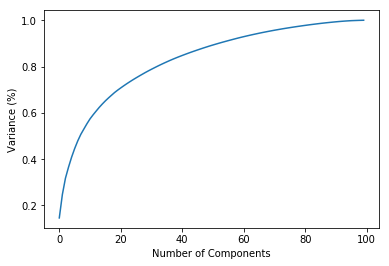

In [22]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

#rescale the data
data = dfv.values
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(data)

pca = PCA().fit(data_rescaled)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.show()

The above calculation says that we should keep about 70 of the 100 principal components to capture over 90% of the variance in the data.

In [23]:
from sklearn.feature_selection import RFECV

#now test the models using this projected dataset
pca = PCA(n_components=60)
data_pca = pca.fit_transform(data_rescaled)
df_pca = pd.DataFrame(data_pca)

rfecv = RFECV(LogisticRegression(), step=1, scoring='f1', cv=10)
rfecv = rfecv.fit(df_pca, labels)
mask = rfecv.support_

drop_features = []
index = 0
for val in mask:
    if not val:
        drop_features.append(index)
    index += 1

df_pca = df_pca.drop(drop_features, axis=1)
print_stats(models, method, df_pca, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.68 ± 0.02,0.61 ± 0.02,0.77 ± 0.04,0.64 ± 0.02,0.72
1,Voting,0.70 ± 0.03,0.67 ± 0.02,0.74 ± 0.04,0.68 ± 0.03,0.75
2,MLP,0.68 ± 0.02,0.67 ± 0.02,0.69 ± 0.03,0.68 ± 0.02,0.75
3,AdaBoost,0.67 ± 0.03,0.66 ± 0.03,0.67 ± 0.03,0.66 ± 0.03,0.73
4,Support Vector Machine,0.67 ± 0.02,0.69 ± 0.02,0.65 ± 0.03,0.68 ± 0.02,0.74


In [24]:
from sklearn.feature_selection import RFECV

#now test the models using this projected dataset
pca = PCA(n_components=40)
data_pca = pca.fit_transform(data_rescaled)
df_pca = pd.DataFrame(data_pca)

rfecv = RFECV(LogisticRegression(), scoring='f1', step=1, cv=10)
rfecv = rfecv.fit(df_pca, labels)
mask = rfecv.support_

drop_features = []
index = 0
for val in mask:
    if not val:
        drop_features.append(index)
    index += 1

df_pca = df_pca.drop(drop_features, axis=1)
print_stats(models, method, df_pca, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.68 ± 0.02,0.62 ± 0.02,0.77 ± 0.03,0.64 ± 0.02,0.72
1,Voting,0.71 ± 0.02,0.67 ± 0.02,0.75 ± 0.03,0.69 ± 0.02,0.76
2,MLP,0.69 ± 0.02,0.69 ± 0.03,0.69 ± 0.04,0.69 ± 0.02,0.75
3,AdaBoost,0.68 ± 0.02,0.67 ± 0.03,0.68 ± 0.02,0.67 ± 0.02,0.73
4,Support Vector Machine,0.67 ± 0.02,0.69 ± 0.03,0.65 ± 0.02,0.68 ± 0.02,0.74


In [25]:
from sklearn.feature_selection import RFECV

#now test the models using this projected dataset
pca = PCA(n_components=20)
data_pca = pca.fit_transform(data_rescaled)
df_pca = pd.DataFrame(data_pca)

rfecv = RFECV(LogisticRegression(), scoring='f1', step=1, cv=10)
rfecv = rfecv.fit(df_pca, labels)
mask = rfecv.support_

drop_features = []
index = 0
for val in mask:
    if not val:
        drop_features.append(index)
    index += 1

df_pca = df_pca.drop(drop_features, axis=1)
print_stats(models, method, df_pca, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.69 ± 0.02,0.62 ± 0.01,0.78 ± 0.04,0.65 ± 0.02,0.72
1,Voting,0.70 ± 0.02,0.66 ± 0.03,0.74 ± 0.02,0.68 ± 0.02,0.76
2,MLP,0.69 ± 0.01,0.68 ± 0.03,0.70 ± 0.01,0.69 ± 0.02,0.76
3,AdaBoost,0.67 ± 0.02,0.66 ± 0.02,0.68 ± 0.02,0.67 ± 0.02,0.73
4,Support Vector Machine,0.67 ± 0.02,0.67 ± 0.03,0.67 ± 0.02,0.67 ± 0.03,0.74


In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

#rescale the data
data = dfv.values
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(data)

models = {'Naive Bayes': GaussianNB(),
          'Voting': VotingClassifier(estimators=[('mlp', MLPClassifier(alpha=0.1)),
                                            ('ada', AdaBoostClassifier(
                                                base_estimator=DecisionTreeClassifier(max_depth=2), 
                                                n_estimators=28, learning_rate=0.35)),
                                            ('SVC', SVC(kernel='rbf', C=10000, gamma=0.01, probability=True)),
                                            ('nb', GaussianNB())], voting='soft'),
          'Perceptron': MLPClassifier(alpha=0.1),
          'AdaBoost': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), 
                                        n_estimators=28, learning_rate=0.35),
          'Support Vector Machine': SVC(kernel='rbf', C=10000, gamma=0.01)}

method = ['Naive Bayes', 'Voting', 'MLP', 'AdaBoost', 'Support Vector Machine']

#now test the models using this projected dataset
pca = PCA(n_components=20)
data_pca = pca.fit_transform(data_rescaled)
df_pca = pd.DataFrame(data_pca)

rfecv = RFECV(LogisticRegression(), step=1, scoring='f1', cv=10)
rfecv = rfecv.fit(df_pca, labels)
mask = rfecv.support_

drop_features = []
index = 0
for val in mask:
    if not val:
        drop_features.append(index)
    index += 1

df_pca = df_pca.drop(drop_features, axis=1)
print_stats(models, method, df_pca, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.69 ± 0.02,0.62 ± 0.02,0.78 ± 0.03,0.65 ± 0.02,0.72
1,Voting,0.70 ± 0.02,0.67 ± 0.02,0.73 ± 0.02,0.68 ± 0.02,0.76
2,MLP,0.69 ± 0.02,0.68 ± 0.02,0.71 ± 0.02,0.69 ± 0.02,0.76
3,AdaBoost,0.67 ± 0.02,0.66 ± 0.03,0.69 ± 0.03,0.67 ± 0.02,0.73
4,Support Vector Machine,0.70 ± 0.02,0.67 ± 0.03,0.73 ± 0.02,0.69 ± 0.03,0.75


## Fine-tune Model Parameters

In [19]:
from sklearn.model_selection import GridSearchCV

#start with MLP
mlp_cv = GridSearchCV(MLPClassifier(), param_grid={
        'activation': ('logistic', 'tanh', 'relu'),
        'solver': ('lbfgs', 'adam'),
        'alpha': (0.0001, 0.001, 0.01),
        'early_stopping': (True, False)}, scoring='f1', cv=10)

mlp_cv.fit(df_pca, labels)
mlp_cv.best_params_

In [48]:
#fine-tuning MLP further
mlp_cv2 = GridSearchCV(MLPClassifier(), param_grid={
        'hidden_layer_sizes': ((20,), (50,), (70,)),
        'alpha': (0.001, 0.01, 0.1)}, scoring='f1', cv=10)

mlp_cv2.fit(df_pca, labels)
mlp_cv2.best_params_

{'alpha': 0.001, 'hidden_layer_sizes': (50,)}

In [53]:
#fine-tuning MLP further
mlp_cv3 = GridSearchCV(MLPClassifier(), param_grid={
        'hidden_layer_sizes': ((40,), (45,), (50,), (55,), (60,)),
        'alpha': (0, 0.0001, 0.0005, 0.001, 0.01)}, scoring='f1', cv=10)

mlp_cv3.fit(df_pca, labels)
mlp_cv3.best_params_

{'alpha': 0.001, 'hidden_layer_sizes': (60,)}

In [ ]:
#fine-tuning MLP further
mlp_cv4 = GridSearchCV(MLPClassifier(alpha=0.001), param_grid={
        'hidden_layer_sizes': ((56,), (58,), (60,), (62,), (64,))}, scoring='f1', cv=10)

mlp_cv4.fit(df_pca, labels)
mlp_cv4.best_params_

In [51]:
pd.DataFrame(mlp_cv2.cv_results_)[['param_hidden_layer_sizes', 'param_alpha', 'mean_test_score', 'rank_test_score']]

,param_hidden_layer_sizes,param_alpha,mean_test_score,rank_test_score
0,"(20,)",0.001,0.690133,8
1,"(50,)",0.001,0.704772,1
2,"(70,)",0.001,0.689332,9
3,"(20,)",0.01,0.697217,4
4,"(50,)",0.01,0.694712,6
5,"(70,)",0.01,0.699084,3
6,"(20,)",0.1,0.691672,7
7,"(50,)",0.1,0.696000,5
8,"(70,)",0.1,0.699873,2


In [ ]:
#fine-tuning MLP further
mlp_cv3 = GridSearchCV(MLPClassifier(), param_grid={
        'hidden_layer_sizes': ((100,), (100,50), (100,75,50)),
        'alpha': (0.001, 0.01, 0.1, 1.0)}, scoring='f1', cv=10)

mlp_cv3.fit(df_pca, labels)
mlp_cv3.best_params_

In [57]:
#now try SVM
svm_cv = GridSearchCV(SVC(kernel=500), param_grid={
        'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
        'degree': (2,3),
    
        'probability': (True, False)}, scoring='f1', cv=10)

svm_cv.fit(df_pca, labels)
svm_cv.best_params_

{'degree': 2, 'kernel': 'rbf', 'probability': True}

In [75]:
#fine-tuning SVM further
svm_cv2 = GridSearchCV(SVC(kernel='rbf'), param_grid={
        'C': [0.001, 0.01, 0.1, 1, 10],
        'gamma': [0.001, 0.01, 0.1, 1],
        'probability': (True, False)}, scoring='f1', cv=10)

svm_cv2.fit(df_pca, labels)
svm_cv2.best_params_

{'C': 10, 'gamma': 0.1, 'probability': True}

In [93]:
#fine-tuning SVM further
svm_cv3 = GridSearchCV(SVC(kernel='rbf'), param_grid={
        'C': [0.1, 1, 10,100],
        'gamma': [0.01, 0.1, 1,10]}, scoring='f1', cv=10)

svm_cv3.fit(df_pca, labels)
svm_cv3.best_params_

{'C': 100, 'gamma': 0.1}

In [97]:
#fine-tuning SVM further
svm_cv4 = GridSearchCV(SVC(kernel='rbf'), param_grid={
        'C': [10,100,1000,10000],
        'gamma': [0.01, 0.1, 1]}, scoring='f1', cv=10)

svm_cv4.fit(df_pca, labels)
svm_cv4.best_params_

{'C': 10000, 'gamma': 0.01}

In [65]:
#now try AdaBoost
ada_cv = GridSearchCV(AdaBoostClassifier(), param_grid={
        'base_estimator': (None, DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)),
        'n_estimators': (50,100, 200),
        'learning_rate': (0.25, 0.5, 1)}, scoring='f1', cv=10)

ada_cv.fit(df_pca, labels)
ada_cv.best_params_

{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'), 'learning_rate': 0.25, 'n_estimators': 50}

In [31]:
#fine-tuning AdaBoost further
ada_cv2 = GridSearchCV(AdaBoostClassifier(), param_grid={
        'base_estimator': (DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)),
        'n_estimators': (10,30,50,100),
        'learning_rate': (0.1, 0.25, 0.5)}, scoring='f1', cv=10)

ada_cv2.fit(df_pca, labels)
ada_cv2.best_params_

{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=None, splitter='best'),
 'learning_rate': 0.25,
 'n_estimators': 30}

In [33]:
#fine-tuning AdaBoost further
ada_cv3 = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2)), param_grid={
        'n_estimators': (25,30,35,40),
        'learning_rate': (0.2,0.25,0.3,0.35)}, scoring='f1', cv=10)

ada_cv3.fit(df_pca, labels)
ada_cv3.best_params_

{'learning_rate': 0.35, 'n_estimators': 30}

In [38]:
#fine-tuning AdaBoost further
ada_cv4 = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2)), param_grid={
        'n_estimators': (28,29,30,31,32),
        'learning_rate': (0.31,0.33,0.35,0.37)}, scoring='f1', cv=10)

ada_cv4.fit(df_pca, labels)
ada_cv4.best_params_

{'learning_rate': 0.35, 'n_estimators': 28}

In [63]:
#finally the voting classifier
voting = VotingClassifier(estimators=[('mlp', MLPClassifier(hidden_layer_sizes=(60,), alpha=0.001)),
                                    ('ada', AdaBoostClassifier(
                                        base_estimator=DecisionTreeClassifier(max_depth=2), 
                                        n_estimators=28, learning_rate=0.35)),
                                    ('SVC', SVC(kernel='rbf', C=10000, gamma=0.01, probability=True)),
                                    ('nb', GaussianNB())])

voting_cv = GridSearchCV(voting, param_grid={'voting': ('hard', 'soft')}, scoring='f1', cv=10)


voting_cv.fit(df_pca, labels)
voting_cv.best_params_

{'voting': 'soft'}

## Random Ideas

In [26]:
#try a bagging classifier
print_stats({'BaggingMLP': BaggingClassifier(base_estimator=MLPClassifier())}, ['BaggingMLP'], dfv, labels)

,Method,f1,precision,recall,accuracy,auc
0,BaggingMLP,0.69 ± 0.02,0.69 ± 0.03,0.70 ± 0.02,0.69 ± 0.02,0.76


In [35]:
print_stats({'Naive Bayes': BaggingClassifier(base_estimator=LinearSVC())}, ['Naive Bayes'], dfv, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.68 ± 0.02,0.69 ± 0.02,0.68 ± 0.02,0.68 ± 0.02,0.75


In [91]:
print_stats({'Naive Bayes': BaggingClassifier(base_estimator=GaussianNB(), n_estimators=200)}, ['Naive Bayes'], df_forest, labels)

,Method,f1,precision,recall,accuracy,auc
0,Naive Bayes,0.68 ± 0.03,0.61 ± 0.02,0.77 ± 0.04,0.64 ± 0.03,0.71


## Balanced Dataset  Generation

In [11]:
#now generate a dataset for MTurk from the subset of 300k tweets
df_subset = pd.read_csv('data/shuffled_subset_all.csv', lineterminator='\n').drop(['Unnamed: 0'], axis=1).loc[1500:,:]
print(df_subset.shape)
df_subset.head()

(364956, 1)


,text
1500,"Ok. Houston, stay home. Stay out of the attic...."
1501,Trump killed flood safety rules 10 days before...
1502,@funder @KariannHart Take that fucking wall do...
1503,water vapor satellite image shows extensive dr...
1504,Alcohol helps cause traffic accidents.\nSmokin...


In [12]:
#a crude way to filter out some donation tweets
prune_indices = df_subset[df_subset['text'].str.contains('donat')].index.values.tolist()
df_subset = df_subset.drop(prune_indices)
print(df_subset.shape)
df_subset.head()

(320472, 1)


,text
1500,"Ok. Houston, stay home. Stay out of the attic...."
1501,Trump killed flood safety rules 10 days before...
1502,@funder @KariannHart Take that fucking wall do...
1503,water vapor satellite image shows extensive dr...
1504,Alcohol helps cause traffic accidents.\nSmokin...


In [13]:
from langdetect import detect

#now get rid of non-English stuff
drop_indices =[]
for index, row in enumerate(df_subset.itertuples()):
    
    if index >= 20000:
        break
    elif index % 10000 == 0:
        print(index)
    
    lang = detect(row.text)
    if lang !='en' and lang != 'nl':
        drop_indices.append(index)

0
10000


In [13]:
#now prune the tweets that are not English
df_english = df_subset.drop(df_subset.index[drop_indices])
df_english.shape

(320373, 1)

In [17]:
df_english_small = df_english.iloc[:20000,:]
print(df_english_small.shape)
df_english_small.head()

(20000, 1)


,text
1500,"Ok. Houston, stay home. Stay out of the attic...."
1501,Trump killed flood safety rules 10 days before...
1502,@funder @KariannHart Take that fucking wall do...
1503,water vapor satellite image shows extensive dr...
1504,Alcohol helps cause traffic accidents.\nSmokin...


In [20]:
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')
df_noemoji = pd.DataFrame(data={'text' : df_english_small['text'].map(deEmojify)})
print(df_noemoji.shape)
df_noemoji.head()

(20000, 1)


,text
1500,"Ok. Houston, stay home. Stay out of the attic...."
1501,Trump killed flood safety rules 10 days before...
1502,@funder @KariannHart Take that fucking wall do...
1503,water vapor satellite image shows extensive dr...
1504,Alcohol helps cause traffic accidents.\nSmokin...


In [21]:
#now preprocess the text
df_test = df_noemoji.copy().reset_index(drop=True)
df_test['Text'] = df_test['text'].map(lambda x: process_tweet(x, tknzr, None, True))
df_test.pop('text')

print(df_test.shape)
df_test.head()

(20000, 1)


,Text
0,ok houston stay home stay attic call <number> ...
1,trump kill flood safety rule <number> days har...
2,<user> <user> take fuck wall <user> hurricaneh...
3,water vapor satellite image show extensive dry...
4,alcohol help cause traffic accidents smoke hel...


In [22]:
#now convert to word embeddings
df_testv = tweets_to_df(df_test, [0]*df_test.shape[0], embeddings, glove).reset_index(drop=True)
df_testv.pop('class')
df_testv.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49
0,-0.043563,0.168890,0.132577,-0.318665,-0.148289,0.082531,0.732835,0.150738,0.097140,-0.027730,...,-0.726723,0.383673,0.364157,-0.003794,0.233437,-0.222859,0.229726,-0.269067,0.002645,0.182357
1,0.198020,0.111794,-0.194317,-0.372960,-0.037570,-0.161805,0.327506,0.018590,0.199540,-0.131544,...,-0.539943,-0.106992,0.183136,-0.061690,0.293251,-0.094791,-0.082968,-0.185012,-0.121363,0.213161
2,0.581150,0.288926,0.154654,-0.169325,0.123784,0.187431,0.353618,0.311923,0.172137,0.650069,...,-1.555811,-0.098209,0.217706,0.436886,0.221757,-0.083573,-0.025337,0.116973,-0.093931,-0.081701
3,-0.213230,-0.330857,0.081841,-0.154605,-0.170297,0.227414,0.515372,-0.379785,0.105189,-0.330809,...,-0.582300,-0.138565,-0.083400,-0.111499,0.082342,0.159363,0.187800,-0.086185,0.011892,0.233976
4,0.094960,0.266487,-0.848661,-0.214325,0.030654,0.126114,0.402066,-0.261091,0.113748,0.007945,...,-0.373645,-0.058034,0.059335,-0.090298,0.071710,-0.197974,0.188452,0.468361,-0.197567,0.282665


In [24]:
#now run the model
mlp = MLPClassifier()
mlp.fit(dfv, labels)
pred = mlp.predict(df_testv)

In [25]:
#now run until we have 5000 positives and 5000 negatives
pos = 0
neg = 0
indices = []
success = False

for index in range(len(pred)):
    p = pred[index]
    if pos == 2400 and neg == 1600:
        success = True
        print('looked through index ' + str(index))
        break
    elif p == 0:
        if neg < 1600:
            indices.append(index)
            neg += 1
    else:
        if pos < 2400:
            indices.append(index)
            pos += 1

print('successful' if success else 'failure')

looked through index 10783
successful


In [26]:
#now make the final dataframe containing 10000 tweets that are relevant and not relevant
df_mturk = df_noemoji.reset_index(drop=True).loc[indices].reset_index(drop=True)
df_mturk

,text
0,"Ok. Houston, stay home. Stay out of the attic...."
1,Trump killed flood safety rules 10 days before...
2,@funder @KariannHart Take that fucking wall do...
3,water vapor satellite image shows extensive dr...
4,Alcohol helps cause traffic accidents.\nSmokin...
5,@TXInstruments @tenethealth @jcpenney can we k...
6,"How horrible, look how high the water is on th..."
7,"Remember those we lost, those who helped us co..."
8,How @SpringISD is helping its community recove...
9,For over 100 yrs @VOATexas has served those in...


In [27]:
df_mturk.to_csv('data/mturk_final4000.csv', index=False)

In [38]:
import sklearn

sklearn.__version__

'0.21.1'